# Lab 3-4: Temporal Difference Learning

## Colab Setup

In [ ]:
# #uncomment only if you're running from google colab
# !ls
# !pip install gym #For full installations, see https://github.com/openai/gym#installation

## Imports

In [1]:
%matplotlib inline

import gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
from tqdm import trange
import seaborn as sns
import pandas as pd
from random import random
from datetime import datetime
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")


from TaxiAgents import TrainTaxiAgent, TaxiAgent, SARSA_TaxiAgent, QLearning_TaxiAgent, ExpectedSARSA_TaxiAgent

# uncomment to see our solution when you finish
#from TaxiAgents_sol import TrainTaxiAgent, TaxiAgent, SARSA_TaxiAgent, QLearning_TaxiAgent, ExpectedSARSA_TaxiAgent


MODEL_PATH = 'models/'

%load_ext autoreload
%autoreload 2
%reload_ext autoreload



## Implement Temporal Difference Learning

Temporal difference (TD) learning is another value-based method for solving a reinforcement learning problem. Main differences between this and the Monte Carlo method we learned are that:

* TD updates the Q-values at every time step; we do not need to run an entire episode beforehand
* TD updates the policy at every timestep


## Let's try [Taxi-v3](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py)

Taxi-v3 is a reinforcment learning environment described in [Dietterich (2000)](https://arxiv.org/abs/cs/9905014) to demonstrate some issues with hierarchical reinforcement learning. The environment features a 5x5 grid with four locations denoted as red, blue, green and yellow. Our agent is a taxi started at any random position. The goal of the environment is to go pick up a passenger at an arbitrary location then send them to their destination as fast as possible.

In [2]:
env = gym.make('Taxi-v3')

Find out what are the following elements

* States:
* Actions:
* Rewards: 

In [4]:
"""
Use this cell to try execute the following functions:
* env.reset() - reset the environment and return the current state
* env.step(action) - take an action at the current state; returns a tuple of (state, reward, done, info)
"""

'\nUse this cell to try execute the following functions:\n* env.reset() - reset the environment and return the current state\n* env.step(action) - take an action at the current state; returns a tuple of (state, reward, done, info)\n'

### Observation Space (State Space)

The state is a single integer from 0 to 499. This is a result of all combinations of:
* 25 taxi positions
* 5 possible locations of the passenger (including the case when the passenger is the taxi)
* 4 destination locations. 
    

In [5]:
env.observation_space

Discrete(500)

In [6]:
env.reset()

64

### Action Space

There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east 
- 3: move west 
- 4: pickup passenger
- 5: dropoff passenger

In [7]:
env.action_space

Discrete(6)

### Reward

* -1 for each action; to finish the task as fast as possible
* +20 for delivering passenger
* -10 for doing `pickup` (4) and `dropoff` (5) illegally
* No penalty for illegal move (the taxi will remain at the same tile)

In [8]:
print(f'State: {env.reset()}')
next_tuple = env.step(0)
print(f'Action: 0, Next state: {next_tuple[0]}, Reward: {next_tuple[1]}')

State: 202
Action: 0, Next state: 302, Reward: -1


In [9]:
env.step(0)

(402, -1, False, {'prob': 1.0})

### Rendering

- blue: passenger
- magenta: destination
- yellow: empty taxi
- green: full taxi
- other letters: locations

In [12]:
env.render(mode = 'human')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


## Human Play - check your understanding by playing the game !

Play a couple of rounds with your own natural neural networks to get a hang of the environment.
Do not forget that:
* blue colored is the location of the passenger  (or green taxi if he is in taxi)
* mangeta color is the destination
* you can take a look at their github implementation inside functions encode and decode if unclear

In [14]:
# Comment this if it's too annoying in your request to run all cells
play = True
if play:
    state = env.reset()
    env.render()

    cumu_reward = 0

    while True:
        action = int(input('Choose action: '))
        state, reward, done, info = env.step(action)
        cumu_reward+=reward
        clear_output(wait=False)
        env.render()
        print(f'Reward: {reward}')
        print(f'Cumulative Reward: {cumu_reward}')
        if reward==20: break

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Reward: -10
Cumulative Reward: -49


KeyError: 6

- 0: Down
- 1: Up
- 2: Right
- 3: Left
- 4: Pickup
- 5: Dropoff

## Now let's try the random / default TaxiAgent in file TaxiAgents.py

First, we define a function that simulates a play and provide statistics using a given TaxiAgent

In [15]:
# These are helper function to print the frames graphically using a given framerate, no need to read it !
from IPython.display import clear_output
import time

# And this is for simulation of an environment, we'll use it later
def simulateEnvironment(env, taxiAgent):
    frames = []
    illegal_moves = 0
    illegal_others = 0
    cumu_reward = 0

    #get initial state
    state = env.reset()

    while True:
        #best action
        action = taxiAgent.select_action(state, taxiAgent.get_epsilon(1e6))

        #step the environment to get (next_state, reward, done, info)
        next_state,reward,done,info =  env.step(action)

        #keep records
        if state==next_state: illegal_moves+=1
        if reward==-10: illegal_others+=1
        cumu_reward+=reward
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward,
            'cumulative_reward': cumu_reward,
            'illegal_moves': illegal_moves,
            'illegal_others': illegal_others
            })

        #set current state to next state
        state = next_state
        
        #print(f"taking action:{action}, next_state is {state}")

        #stop game if done; there's a bug with taxi-v2 that cuts your game over if you have not solved it in 200 timesteps
        if reward==20: break
            
    print_frames(frames)

def print_frames(frames,wait_time=0.2):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        print(f"Cumulative Reward: {frame['cumulative_reward']}")
        print(f"Illegal Moves: {frame['illegal_moves']}")
        print(f"Illegal Others: {frame['illegal_others']}")
        time.sleep(wait_time)
              


### Computer Play

Our benchmark will be the final cumulative reward, from now on called `score`, at the end of an episode over time. For instance, when we do 1,000 episodes, as our agent becomes smarter, the cumulative rewards should get better and better. OpenAI uses 100-episode average score as their benchmark for "solving" the environment. **The solving score for this environment is 8.5.**


**IMPORTANT QUESTION:** Why is it a bad idea to use Monte Carlo method for this environment?

**IMPORTANT** Study they code for function TrainTaxiAgent to see the whole training loop, inside TaxiAgents.py file 

## Task 1: Implement SARSA in TaxiAgents.py, class SARSA_TaxiAgent.py. 
### You will have to implement only the updateExperience function, but make sure you understand rest of the code and parent class as well
### Then let it play below to see that it is really working

Check the course again to remember the details.
SARSA is the most basic of temporal difference learning. It got its name from the tuples we used for the learning:

$$S_0 \rightarrow A_0 \rightarrow R_1 \rightarrow S_1 \rightarrow A_1 \rightarrow R_2 \rightarrow S_2 \rightarrow ... \rightarrow S_{t-1} \rightarrow A_{t-1} \rightarrow R_t \rightarrow S_{t}$$

And since action value $Q(s,a)$ is **expected** discounted rewards, we can substitute $Q(s_{t+1},a_{t+1})$ for $G_{t+1}$. And with each time step, we update the action values as:

$$Q(s_t,a_t) = Q(s_t,a_t) + \alpha (R_{t+1} + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))$$

where:
* $\alpha$ is the learning rate
* $Q(s_t,a_t)$ is the action value for that state-action pair

For every **timestep**
* **Step 1** Given state $s_t$, choose an action $a_t$ using epsilon greedy policy
* **Step 2** Take that action and observe next state ($s_{t+1}$) and reward ($r_{t+1}$)
* **Step 3** Update the action value $Q(s_t,a_t)$ using the equation above

In [21]:
# Let's create a SARSA playing agent and simulate a play rendering
sarsaAgent = SARSA_TaxiAgent(env)
lastEpisodeFrames = TrainTaxiAgent(env, sarsaAgent, numEpisodes=100000, plotStats=True, storeFramesDescription=False)

  3%|▎         | 3429/100000 [23:03<317:16:10, 11.83s/it]

In [ ]:
print(sarsaAgent.q)

# Then check your first smart agent how it deals on plain simulation
# Run it multiple times !!
simulateEnvironment(env, sarsaAgent)            


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 118
State: 97
Action: 5
Reward: 20
Cumulative Reward: -475
Illegal Moves: 66
Illegal Others: 42


## Task 2: Implement Q-learning (also known as SARSAMAX) in TaxiAgents.py, class QLearning_TaxiAgent.py. 
### You will have to implement only the updateExperience function, but make sure you understand rest of the code and parent class as well

Q-learning or SARSAMAX is perhaps the most well-known RL algorithm due to Deepminds' [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) paper in 2013. There are some significant contributions made by that paper such as using deep learning as function approximation instead of a dictionary, experience replay, and fixed target for learning. But the principle of the learning remains largely the same as the algorithm we will learn today.

For every **timestep**
* **Step 1** Given state $s_t$, choose an action $a_t$ using epsilon greedy policy
* **Step 2** Update the action value $Q(s_t,a_t)$ using the following equation:

$Q(s_t,a_t) = Q(s_t,a_t) + \alpha (R_{t+1} + \gamma max_{a}Q(s_{t+1},a) - Q(s_t,a_t))$

where $max_{a}Q(s_{t+1},a)$ is the highest action value given state $s_{t+1}$. 

This is very similar to SARSA except for the fact that we will always choose the best action-value as opposed to epsilon-greedy action selection of SARSA. For this reason, SARSA is called **on-policy** and Q-learning **off-policy**.


In [ ]:
# Let's create a QLearning playing agent and simulate a play rendering
qlearningAgent = QLearning_TaxiAgent(env)
lastEpisodeFrames = TrainTaxiAgent(env, qlearningAgent, numEpisodes=100000, plotStats=True, storeFramesDescription=False)

In [ ]:
# Then check your secomd smart agent how it deals on plain simulation
# Run it multiple times !!
simulateEnvironment(env, qlearningAgent)            


## Task 3: Implement Expected SARSA  in TaxiAgents.py, class ExpectedSARSA_TaxiAgent.py.

Expected SARSA is another way we can update the Q values, not with maximum action values but with all the actions value weighted by their probability (in our case of the epsilon-greedy policy).

For every **timestep**
* **Step 1** Given state $s_t$, choose an action $a_t$ using epsilon greedy policy
* **Step 2** Update the action value $Q(s_t,a_t)$ using the following equation:

$$Q(s_t,a_t) = Q(s_t,a_t) + \alpha (R_{t+1} + \gamma \sum_{a}\pi(a|s_{t+1})Q(s_{t+1},a) - Q(s_t,a_t))$$

where $\pi(a|s_{t+1})$ is the probability of taking an action $a$.

100%|██████████| 100000/100000 [04:44<00:00, 351.02it/s]


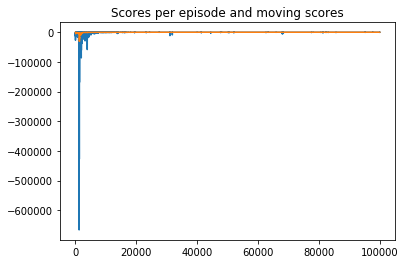

Last 100-episode average score at the end of simulation: -2.2


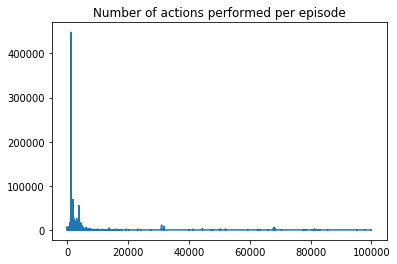

No handles with labels found to put in legend.


Last 100-episode average number of actions performed: 94.15402402402403
Illegal moves in the last episode: 0; Illegal drop-offs/pickups in the last episode: 0


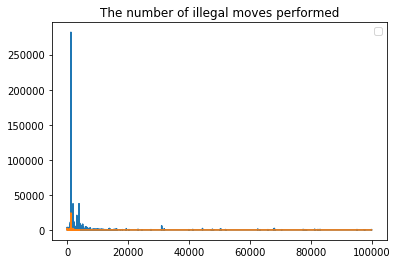

In [ ]:
# Let's create a RANDOM playing agent and simulate a play rendering
expectedSarsaAgent = ExpectedSARSA_TaxiAgent(env)
lastEpisodeFrames = TrainTaxiAgent(env, expectedSarsaAgent, numEpisodes=100000, plotStats=True, storeFramesDescription=False)

In [ ]:
# Then check your third smart agent how it deals on plain simulation
# Run it multiple times !!
simulateEnvironment(env, expectedSarsaAgent)    

NameError: name 'expectedSarsaAgent' is not defined

## On your own experiments

The OpenAI scoreboard lists 9.7 as the high score. This requires you to do some hyperparameter tuning over time of gamma, alpha and epsilon. Try to implement `get_alpha` and `get_gamma` methods in addition to `get_epsilon` and increase/decrease your hyperparameters as the training goes on. Here are some hints:

* `gamma`: you would want to focus more on near-term rewards as time goes on as your agent is more aware of the action values of the states
* `alpha`: you would want to learn more slowly as time goes on as your agent has already accumulated a lot of knowledge about the environment
* `epsilon`: you would want to do less random action as time goes on as your best actions are probably really best.

<img src="img/taxi_scores.PNG" alt="OpenAI Learderboard" />